In [26]:
import re
import random
import time
from statistics import mode

from PIL import Image, ImageStat
from tqdm import tqdm
import numpy as np
import pandas
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms
import torch.nn.functional as F

In [27]:
import matplotlib.pyplot as plt

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [29]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [30]:
def process_text_adv(text):
    # lowercase
    text = text.lower()

    # 数詞を数字に変換
    num_word_to_digit = {
        'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
        'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
        'ten': '10', 
    }
    for word, digit in num_word_to_digit.items():
        text = text.replace(word, digit)

    # 小数点のピリオドを削除
    text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

    # 冠詞の削除
    text = re.sub(r'\b(a|an|the)\b', '', text)

    # 短縮形のカンマの追加
    contractions = {
        "dont": "don't", "isnt": "isn't", "arent": "aren't", "wont": "won't",
        "cant": "can't", "wouldnt": "wouldn't", "couldnt": "couldn't", "whats": "what's",
        "thats": "that's", "whos": "who's", "wheres": "where's", "whens": "when's",
        "please":"", "could you": "can you", "could i": "can i", "could we": "can we",
    }

    contractions_2 = {
        "theatre" : "theater", "colour" : "color", "centre" : "center", "favourite" : "favorite",
        "travelling" : "traveling", "counselling" : "counseling", "metre" : "meter",
        "cancelled" : "canceled", "labour" : "labor", "organisation" : "organization",
        "calibre" : "caliber", "cheque" : "check", "manoeuvre" : "maneuver",
        "neighbour" : "neighbor", "grey" : "gray", "dialogue" : "dialog",
    }

    contractions_3 = {
        "what is": "what's", "who is": "who's", "where is": "where's", "when is": "when's",
        "how is": "how's", "it is": "it's", "he is": "he's", "she is": "she's",
        "that is": "that's", "there is": "there's", "here is": "here's",
        "i am": "i'm", "you are": "you're", "we are": "we're", "they are": "they're",
        "i have": "i've", "you have": "you've", "we have": "we've", "they have": "they've",
        "i will": "i'll", "you will": "you'll",
    }
    # contractions_3 = {
    #     "what's" : "what is", "who's" : "who is", "where's" : "where is", "when's" : "when is",
    #     "how's" : "how is", "it's" : "it is", "he's" : "he is", "she's" : "she is",
    #     "that's" : "that is", "there's" : "there is", "here's" : "here is",
    #     "i'm" : "i am", "you're" : "you are", "we're" : "we are", "they're" : "they are",
    #     "i've" : "i have", "you've" : "you have", "we've" : "we have", "they've" : "they have",
    #     "i'll" : "i will", "you'll" : "you will",
    # }
 
    for contraction, correct in contractions.items():
        text = text.replace(contraction, correct)
    for contraction, correct in contractions_2.items():
        text = text.replace(contraction, correct)
    for contraction, correct in contractions_3.items():
        text = text.replace(contraction, correct)

    # 句読点をスペースに変換
    text = re.sub(r"[^\w\s':]", ' ', text)

    # 句読点をスペースに変換
    text = re.sub(r'\s+,', ',', text)

    # 連続するスペースを1つに変換
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [31]:
def process_text(text):
    # lowercase
    text = text.lower()

    # 数詞を数字に変換
    num_word_to_digit = {
        'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
        'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
        'ten': '10'
    }
    for word, digit in num_word_to_digit.items():
        text = text.replace(word, digit)

    # 小数点のピリオドを削除
    text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

    # 冠詞の削除
    text = re.sub(r'\b(a|an|the)\b', '', text)

    # 短縮形のカンマの追加
    contractions = {
        "dont": "don't", "isnt": "isn't", "arent": "aren't", "wont": "won't",
        "cant": "can't", "wouldnt": "wouldn't", "couldnt": "couldn't"
    }
    for contraction, correct in contractions.items():
        text = text.replace(contraction, correct)

    # 句読点をスペースに変換
    text = re.sub(r"[^\w\s':]", ' ', text)

    # 句読点をスペースに変換
    text = re.sub(r'\s+,', ',', text)

    # 連続するスペースを1つに変換
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [32]:
# 1. データローダーの作成
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, df_path, image_dir, transform=None, transform_adv=None, answer=True):
        self.transform = transform  # 画像の前処理
        self.transform_adv = transform_adv  # 画像の前処理
        self.image_dir = image_dir  # 画像ファイルのディレクトリ
        self.df = pandas.read_json(df_path)  # 画像ファイルのパス，question, answerを持つDataFrame
        print(f"df shape: {self.df.shape}")
        
        self.answer = answer

        # question / answerの辞書を作成
        self.question2idx = {}
        self.answer2idx = {}
        self.idx2question = {}
        self.idx2answer = {}
        c1 = c2 = c3 = c4 = c5 = c6 = c7 = 0

        # 質問文の最大長を取得
        self.max_question_length = 0

        # 質問文に含まれる単語を辞書に追加
        for question in self.df["question"]:
            question = process_text_adv(question)
            words = question.split(" ")

            if len(words) > self.max_question_length:
                self.max_question_length = len(words)
            
            for idex, word in enumerate(words):            
                if word not in self.question2idx:
                    self.question2idx[word] = len(self.question2idx)

        
        self.idx2question = {v: k for k, v in self.question2idx.items()}  # 逆変換用の辞書(question)

        self.answer2idx["<unk>"] = 0

        if self.answer:
            # 回答に含まれる単語を辞書に追加
            for answers in self.df["answers"]:
                for answer in answers:
                    word = answer["answer"]
                    word = process_text(word)
                    if word not in self.answer2idx:
                        self.answer2idx[word] = len(self.answer2idx)
            
            self.idx2answer = {v: k for k, v in self.answer2idx.items()}  # 逆変換用の辞書(answer)

            # print(f"answer{self.idx2answer}")

    def update_dict(self, dataset):
        """
        検証用データ，テストデータの辞書を訓練データの辞書に更新する．

        Parameters
        ----------
        dataset : Dataset
            訓練データのDataset
        """
        self.question2idx = dataset.question2idx
        self.answer2idx = dataset.answer2idx
        self.idx2question = dataset.idx2question
        self.idx2answer = dataset.idx2answer

    def __getitem__(self, idx, isKL=False):
        """
        対応するidxのデータ（画像，質問，回答）を取得．

        Parameters
        ----------
        idx : int
            取得するデータのインデックス

        Returns
        -------
        image : torch.Tensor  (C, H, W)
            画像データ
        question : torch.Tensor  (vocab_size)
            質問文をone-hot表現に変換したもの
        answers : torch.Tensor  (n_answer)
            10人の回答者の回答のid
        mode_answer_idx : torch.Tensor  (1)
            10人の回答者の回答の中で最頻値の回答のid
        """
        image = Image.open(f"{self.image_dir}/{self.df['image'][idx]}").convert("RGB")
        
        # image = self.transform(image)
        question = np.zeros(len(self.idx2question) + 1)  # 未知語用の要素を追加
        question_vector = []
        # question_words = self.df["question"][idx].split(" ")
        question_text = process_text_adv(self.df["question"][idx])
        question_words = question_text.split(" ")

        is_positional_question = False

        for i in range(self.max_question_length - len(question_words)):
            question_vector.insert(0, 0)
    
        for word in question_words:
            if not is_positional_question and (word == "where" or word == "right" or word == "left" or word == "top" or word == "bottom" or word == "position"):
                is_positional_question = True  
            try:
                question[self.question2idx[word]] = 1  # one-hot表現に変換
                question_vector.append(self.question2idx[word])
            except KeyError:
                question[-1] = 1  # 未知語
                question_vector.append(0)
        
        # if is_positional_question:
        #     print(f"positional question: {question_words}")
        # else:
        #     print(f"NOT positional question: {question_words}")

        if self.answer:
            answers_prevector = np.zeros(len(self.answer2idx))
            answers = [self.answer2idx[process_text(answer["answer"])] for answer in self.df["answers"][idx]]
            for answer in answers:
                answers_prevector[answer] += 1
            sum_answers = max(np.sum(answers_prevector), 1e-10)
            answers_vector = answers_prevector / sum_answers
            mode_answer_idx = mode(answers)  # 最頻値を取得（正解ラベル）

            if is_positional_question or self.transform_adv is None:
                image = self.transform(image)
            else:
                image = self.transform_adv(image)

            return image, torch.Tensor(question), torch.Tensor(answers), int(mode_answer_idx), torch.Tensor(answers_vector), torch.LongTensor(question_vector)

        else:

            if is_positional_question or self.transform_adv is None:
                image = self.transform(image)
            else:
                image = self.transform_adv(image)

            return image, torch.Tensor(question), torch.LongTensor(question_vector)

    def __len__(self):
        return len(self.df)

In [33]:
def loadVQAData(df_path, image_dir, transform=None, answer=True):
    return VQADataset(df_path, image_dir, transform, answer)

In [34]:
# 2. 評価指標の実装
# 簡単にするならBCEを利用する
def VQA_criterion(batch_pred: torch.Tensor, batch_answers: torch.Tensor):
    total_acc = 0.

    for pred, answers in zip(batch_pred, batch_answers):
        acc = 0.
        for i in range(len(answers)):
            num_match = 0
            for j in range(len(answers)):
                if i == j:
                    continue
                if pred == answers[j]:
                    num_match += 1
            acc += min(num_match / 3, 1)
        total_acc += acc / 10

    return total_acc / len(batch_pred)

In [35]:
# 3. モデルのの実装
# ResNetを利用できるようにしておく
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

In [36]:
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

In [37]:
class ResNet(nn.Module):
    def __init__(self, block, layers):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, layers[0], 64)
        self.layer2 = self._make_layer(block, layers[1], 128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], 256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 512)

    def _make_layer(self, block, blocks, out_channels, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [38]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [39]:
def ResNet50():
    return ResNet(BottleneckBlock, [3, 4, 6, 3])

In [40]:
from torchvision.models import resnet34, ResNet34_Weights, Wide_ResNet50_2_Weights, wide_resnet50_2

class VQAModel(nn.Module):
    def __init__(self, vocab_size: int, n_answer: int):
        super().__init__()
        # self.resnet = ResNet18()
        self.resnet = torchvision.models.resnet34(weights=ResNet34_Weights.DEFAULT)
        # self.resnet = torchvision.models.wide_resnet50_2(weights=Wide_ResNet50_2_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(512, 512)
        self.text_encoder = nn.Linear(vocab_size, 512)

        self.word_embeddings = nn.Embedding(vocab_size, 512, padding_idx=0)
        # batch_first=Trueが大事！
        self.lstm = nn.LSTM(512, 512, batch_first=True)

        self.hidden2tag = nn.Linear(512, 512)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, n_answer)

        self.dropout = nn.Dropout(0.1)

        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(inplace=True),
            nn.Linear(512, n_answer)
        )

    def forward(self, image, question):
        image_feature = self.resnet(image)  # 画像の特徴量
        # question_feature = self.text_encoder(question)  # テキストの特徴量

        embeds = self.word_embeddings(question)
        #embeds.size() = (batch_size × len(sentence) × embedding_dim)
        _, lstm_out = self.lstm(embeds)
        # x = torch.cat([image_feature, lstm_out[0].squeeze()], dim=1)

        tag_space = self.hidden2tag(lstm_out[0])
        question_feature = F.leaky_relu(torch.squeeze((tag_space + lstm_out[0]), dim=0))

        # x = torch.cat([image_feature, tag_space.squeeze()], dim=1)
        x = torch.cat([image_feature, question_feature], dim=1)

        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        y = self.fc2(x)
        x = F.leaky_relu((x + y))
        x = self.fc3(x)

        return x

In [41]:
def softmax(x, axis=1):
    x -= x.max(axis, keepdims=True) # expのoverflowを防ぐ
    x_exp = np.exp(x)
    return x_exp / x_exp.sum(axis, keepdims=True)

In [42]:
# 4. 学習の実装
def train_KL(model, dataloader, optimizer, criterion, device):
    model.train()
    eps = 1e-8

    total_loss = 0
    total_acc = 0
    simple_acc = 0

    start = time.time()
    for image, question, answers, mode_answer, answers_vector , question_vector in tqdm(dataloader):
        image, question, answer, mode_answer, answers_vector, question_vector = \
            image.to(device), question.to(device), answers.to(device), mode_answer.to(device), answers_vector.to(device), question_vector.to(device)

        pred = model(image, question_vector)
        nn_softmax = nn.Softmax(dim=1)
        softmax_pred = nn_softmax(pred)

        loss = criterion(torch.log(softmax_pred + eps), answers_vector + eps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += VQA_criterion(pred.argmax(1), answers)  # VQA accuracy
        simple_acc += (pred.argmax(1) == mode_answer).float().mean().item()  # simple accuracy

    return total_loss / len(dataloader), total_acc / len(dataloader), simple_acc / len(dataloader), time.time() - start

In [43]:
# 4. 学習の実装_normal
def train(model, dataloader, optimizer, criterion, device):
    model.train()

    total_loss = 0
    total_acc = 0
    simple_acc = 0

    start = time.time()
    for image, question, answers, mode_answer, answers_vector in tqdm(dataloader):
        image, question, answer, mode_answer, answers_vector = \
            image.to(device), question.to(device), answers.to(device), mode_answer.to(device), answers_vector.to(device)

        pred = model(image, question)
        loss = criterion(pred, mode_answer.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += VQA_criterion(pred.argmax(1), answers)  # VQA accuracy
        simple_acc += (pred.argmax(1) == mode_answer).float().mean().item()  # simple accuracy

    return total_loss / len(dataloader), total_acc / len(dataloader), simple_acc / len(dataloader), time.time() - start

In [44]:
def eval(model, dataloader, optimizer, criterion, device):
    model.eval()

    total_loss = 0
    total_acc = 0
    simple_acc = 0

    start = time.time()
    for image, question, answers, mode_answer, answers_vector in dataloader:
        image, question, answer, mode_answer, answers_vector = \
            image.to(device), question.to(device), answers.to(device), mode_answer.to(device), answers_vector.to(device)

        pred = model(image, question)
        loss = criterion(pred, mode_answer.squeeze())

        total_loss += loss.item()
        total_acc += VQA_criterion(pred.argmax(1), answers)  # VQA accuracy
        simple_acc += (pred.argmax(1) == mode_answer).mean().item()  # simple accuracy

    return total_loss / len(dataloader), total_acc / len(dataloader), simple_acc / len(dataloader), time.time() - start

In [45]:
set_seed(42)

# dataloader / model
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_train_adv = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = VQADataset(df_path="./data/trainv3.json", image_dir="./data/train", transform=transform_train, transform_adv=transform_train_adv, answer=True)
test_dataset = VQADataset(df_path="./data/valid.json", image_dir="./data/valid", transform=transform_test, answer=False)
test_dataset.update_dict(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


df shape: (28564, 3)
df shape: (4969, 2)


In [46]:
# cosine scheduler
class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length=5):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)

        return lr

In [47]:
def set_lr(lr, optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [48]:
model = VQAModel(vocab_size=len(train_dataset.question2idx)+1, n_answer=len(train_dataset.answer2idx)).to(device)
print(model)

VQAModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [49]:
# optimizer / criterion
num_epoch = 20
warmup_length = 3
lr = 0.001
criterion = nn.CrossEntropyLoss()
criterion_KL = nn.KLDivLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

scheduler = CosineScheduler(num_epoch, lr, warmup_length)

In [50]:
train_loss_hist = []
train_acc_hist = []
train_lr_hist = []

# train model
for epoch in range(num_epoch):
    new_lr = scheduler(epoch)
    set_lr(new_lr, optimizer)
    train_lr_hist.append(new_lr)
    
    # train_loss, train_acc, train_simple_acc, train_time = train(model, train_loader, optimizer, criterion, device)
    train_loss, train_acc, train_simple_acc, train_time = train_KL(model, train_loader, optimizer, criterion_KL, device)
    print(f"【{epoch + 1}/{num_epoch}】\n"
            f"train time: {train_time:.2f} [s]\n"
            f"train loss: {train_loss:.4f}\n"
            f"train acc: {train_acc:.4f}\n"
            f"train simple acc: {train_simple_acc:.4f}\n"
            f"train lr: {new_lr:.6f}\n")
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

100%|██████████| 224/224 [11:31<00:00,  3.09s/it]


【1/20】
train time: 691.44 [s]
train loss: 752.5413
train acc: 0.3936
train simple acc: 0.3237
train lr: 0.000333



100%|██████████| 224/224 [10:15<00:00,  2.75s/it]


【2/20】
train time: 615.15 [s]
train loss: 610.7871
train acc: 0.4396
train simple acc: 0.3656
train lr: 0.000667



100%|██████████| 224/224 [10:14<00:00,  2.74s/it]


【3/20】
train time: 614.34 [s]
train loss: 534.1012
train acc: 0.4543
train simple acc: 0.3780
train lr: 0.001000



100%|██████████| 224/224 [10:16<00:00,  2.75s/it]


【4/20】
train time: 616.72 [s]
train loss: 459.2391
train acc: 0.4706
train simple acc: 0.3948
train lr: 0.001000



100%|██████████| 224/224 [10:17<00:00,  2.76s/it]


【5/20】
train time: 617.40 [s]
train loss: 394.2416
train acc: 0.4846
train simple acc: 0.4096
train lr: 0.000991



100%|██████████| 224/224 [10:15<00:00,  2.75s/it]


【6/20】
train time: 616.00 [s]
train loss: 333.4969
train acc: 0.5028
train simple acc: 0.4294
train lr: 0.000966



100%|██████████| 224/224 [10:20<00:00,  2.77s/it]


【7/20】
train time: 620.26 [s]
train loss: 278.3242
train acc: 0.5341
train simple acc: 0.4596
train lr: 0.000925



100%|██████████| 224/224 [10:15<00:00,  2.75s/it]


【8/20】
train time: 615.72 [s]
train loss: 234.1238
train acc: 0.5758
train simple acc: 0.4936
train lr: 0.000870



100%|██████████| 224/224 [10:15<00:00,  2.75s/it]


【9/20】
train time: 615.32 [s]
train loss: 201.7444
train acc: 0.6137
train simple acc: 0.5267
train lr: 0.000801



100%|██████████| 224/224 [10:18<00:00,  2.76s/it]


【10/20】
train time: 618.36 [s]
train loss: 173.7773
train acc: 0.6568
train simple acc: 0.5630
train lr: 0.000723



100%|██████████| 224/224 [10:20<00:00,  2.77s/it]


【11/20】
train time: 620.21 [s]
train loss: 151.4294
train acc: 0.6886
train simple acc: 0.5907
train lr: 0.000637



100%|██████████| 224/224 [10:22<00:00,  2.78s/it]


【12/20】
train time: 622.30 [s]
train loss: 131.8357
train acc: 0.7238
train simple acc: 0.6217
train lr: 0.000546



100%|██████████| 224/224 [10:22<00:00,  2.78s/it]


【13/20】
train time: 622.32 [s]
train loss: 114.0243
train acc: 0.7565
train simple acc: 0.6529
train lr: 0.000454



100%|██████████| 224/224 [10:22<00:00,  2.78s/it]


【14/20】
train time: 622.72 [s]
train loss: 99.0024
train acc: 0.7850
train simple acc: 0.6820
train lr: 0.000363



100%|██████████| 224/224 [10:18<00:00,  2.76s/it]


【15/20】
train time: 618.33 [s]
train loss: 85.9996
train acc: 0.8096
train simple acc: 0.7089
train lr: 0.000277



100%|██████████| 224/224 [10:18<00:00,  2.76s/it]


【16/20】
train time: 618.20 [s]
train loss: 76.3615
train acc: 0.8275
train simple acc: 0.7278
train lr: 0.000199



100%|██████████| 224/224 [10:19<00:00,  2.76s/it]


【17/20】
train time: 619.11 [s]
train loss: 68.1258
train acc: 0.8463
train simple acc: 0.7517
train lr: 0.000130



100%|██████████| 224/224 [10:23<00:00,  2.78s/it]


【18/20】
train time: 623.18 [s]
train loss: 62.0986
train acc: 0.8613
train simple acc: 0.7708
train lr: 0.000075



100%|██████████| 224/224 [10:25<00:00,  2.79s/it]


【19/20】
train time: 625.25 [s]
train loss: 58.8717
train acc: 0.8664
train simple acc: 0.7785
train lr: 0.000034



100%|██████████| 224/224 [10:24<00:00,  2.79s/it]

【20/20】
train time: 624.09 [s]
train loss: 56.8133
train acc: 0.8709
train simple acc: 0.7859
train lr: 0.000009



In [51]:
# 提出用ファイルの作成
model.eval()
submission = []
for image, question, question_vector in tqdm(test_loader):
    image, question, question_vector = image.to(device), question.to(device), question_vector.to(device)
    pred = model(image, question_vector)
    pred = pred.argmax(1).cpu().item()
    submission.append(pred)

submission = [train_dataset.idx2answer[id] for id in submission]
submission = np.array(submission)
torch.save(model.state_dict(), "model.pth")
np.save("submission.npy", submission)

100%|██████████| 4969/4969 [02:51<00:00, 28.93it/s]


ValueError: x and y must have same first dimension, but have shapes (1,) and (20,)

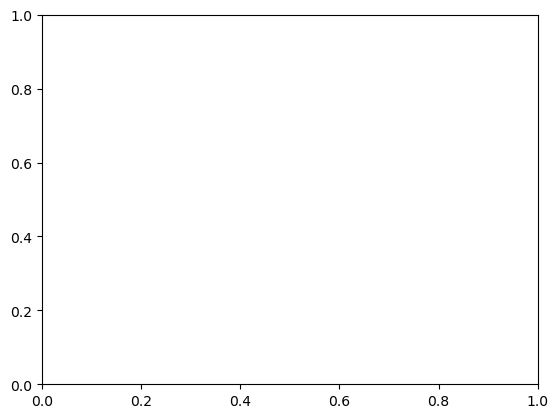

In [52]:
plt.plot(num_epoch, train_loss_hist, 'bo', label='Training loss')
plt.plot(num_epoch, train_acc_hist, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
plt.plot(num_epoch, train_lr_hist, 'b', label='Learning rate')
plt.title('Training and validation loss')
plt.legend()